In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_gp
import time
import numpy as np
import cupy as cp
import multiprocess
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

local


In [2]:
train_data = kgs.load_all_train_data()
train_data = train_data
kgs.debugging_mode = 1
model = ariel_gp.PredictionModel()
model.run_in_parallel = False
model.model_options.n_iter=0
model.model_options.use_training_labels = True
kgs.sanity_checks_active = True
model.train(train_data)

In [3]:
def f(d):
    import kaggle_support as kgs
    import numpy as np
    import copy
    import scipy.interpolate
    import cupy as cp
    import ariel_load
    kgs.debugging_mode = 1
    #model = kgs.dill_load(kgs.temp_dir + '/parallel.pickle')
    #d = model.infer([d])[0]
    d.load_to_step(2, ariel_load.default_loaders())
    obs_transit = d.diagnostics['transit']
    for i_wavelength in range(1):
        if i_wavelength==0:
            times_obs = np.unique(obs_transit.df['time'][~obs_transit.df['is_AIRS']])
            transit_obs = obs_transit.export_matrix(False)[:,0]
            times_data = d.transits[0].data[0].times.get()/3600   
            transit_data = cp.array(scipy.interpolate.interp1d(times_obs, transit_obs, kind='cubic', fill_value="extrapolate")(times_data))
            times_data = cp.array(times_data)     
            data = d.transits[0].data[0].data
            data = np.reshape(data, (data.shape[0],-1))
        else:
            raise 'todo'
        N, M = data.shape
        #print(data.shape, transit_data.shape)

        # Design matrix for linear model: [x, 1]
        X = cp.column_stack((transit_data, cp.ones(N)))  # shape (N, 2)

        # Solve least squares for all columns at once
        # lstsq solves min ||X @ coef - y||_2 for each column in data
        coefs, _, _, _ = cp.linalg.lstsq(X, data, rcond=None)  # coefs shape: (2, M)

        a = coefs[0]  # slopes (M,)
        b = coefs[1]  # intercepts (M,)
        #print(cp.nanmean(b))
    return (a,b)

In [4]:
# loaded_res = kgs.dill_load(kgs.temp_dir + '/prep.pickle')
# model.infer(train_data[0:1]);
# for d,r in tqdm(zip(train_data,loaded_res)):
#     model.results['model_mean'].set_parameters(r[0])
#     obs_transit = copy.deepcopy(model.results['obs'])
#     obs_transit.labels = model.results['model_mean'].m['signal'].m['transit'].get_prediction(obs_transit)
#     d.diagnostics['transit'] = obs_transit
# del loaded_res
# data = train_data
# with multiprocess.Pool(1) as p:                   
#     result = list(tqdm(
#         p.imap(f, data),
#         total=len(data),
#         desc="Processing in parallel", smoothing = 0.05
#         ))
# kgs.dill_save(kgs.temp_dir + '/explore_base_shape.pickle', result)
result = kgs.dill_load(kgs.temp_dir + '/explore_base_shape.pickle')

/tmp/ipykernel_15017/3148245239.py:12: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(x))


78.82038820114778


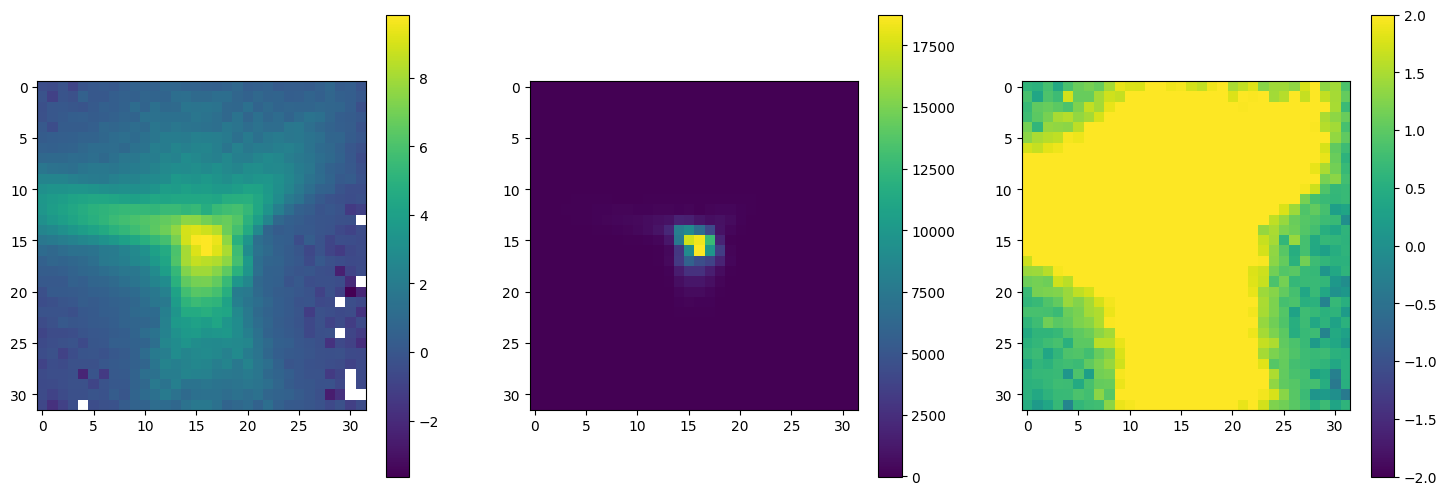

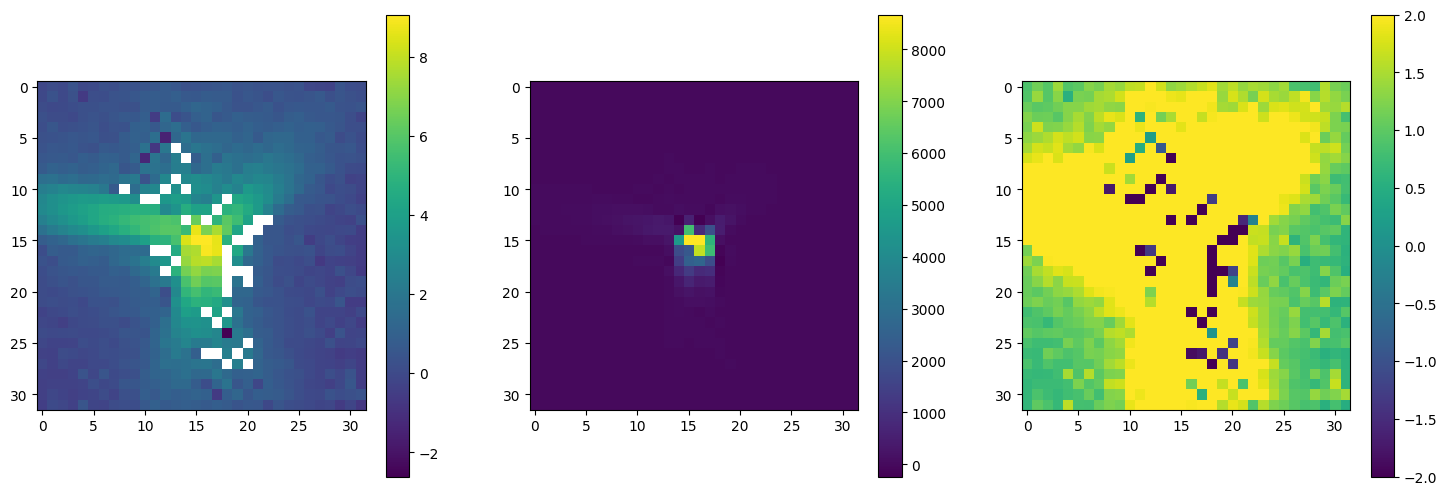

In [7]:
all_a = cp.stack([r[0] for r in result])
all_b = cp.stack([r[1] for r in result])
#all_a_scaled = cp.stack([r[0]/cp.sqrt(cp.nanmean(r[0]**2)) for r in result])
#all_a_scaled = all_a_scaled*cp.sqrt(cp.nanmean(all_a[0]**2))/cp.sqrt(cp.nanmean(all_a_scaled[0]**2))
a = cp.nanmedian(all_a,0)
b = cp.nanmedian(all_b,0)
def plot_all(x):
    x = x.get().reshape(32,32)
    #x = x[12:20,12:20]
    _,ax=plt.subplots(1,3,figsize=(18,6))
    plt.sca(ax[0])
    plt.imshow(np.log(x))
    plt.colorbar()
    plt.sca(ax[1])
    plt.imshow(x)
    plt.colorbar()
    plt.sca(ax[2])
    plt.imshow(x)
    plt.clim([-2,2])
    plt.colorbar()
plot_all(a)
#plot_all(cp.nanmedian(all_a_scaled,0))
plot_all(b)
print(cp.nanmean(b))

In [6]:
cp.sum(~cp.isnan(all_a_scaled))

NameError: name 'all_a_scaled' is not defined

In [ ]:
#plt.plot(cp.nanmean(all_b,1).get())
print(np.max(cp.nanmedian(all_b,0).get()))
ind = np.argmax(cp.nanmedian(all_b,0).get())
plt.plot(all_b[:,ind].get())
np.nanmedian(all_b[:,ind].get())
#plot_all(all_a[ind,:])
#plot_all(all_b[ind,:])

In [ ]:
import ariel_numerics
import importlib
importlib.reload(ariel_numerics)
weights,components,S = ariel_numerics.nan_pca(all_a-a, 10, tol=1e-5, verbose=True)
plt.figure();plt.plot(S.get())
plt.figure();plt.imshow(a.reshape(32,32).get())
plt.figure();plt.imshow(components[0,:].reshape(32,32).get())
plt.figure();plt.imshow(components[1,:].reshape(32,32).get())

In [ ]:
import ariel_numerics
import importlib
importlib.reload(ariel_numerics)
weights2,components2,S2 = ariel_numerics.nan_pca(all_b-b, 10, tol=1e-5, verbose=True)
plt.figure();plt.plot(S.get())
plt.figure();plt.imshow(b.reshape(32,32).get())
plt.figure();plt.imshow(components2[0,:].reshape(32,32).get())
plt.figure();plt.imshow((components2[1,:]).reshape(32,32).get())

In [ ]:
weights.shape

In [ ]:
S,S2